In [1]:
# packages required for new environment
# ! pip install pandas
# ! pip install nltk
# ! pip install datasets
# ! pip install tqdm
# ! pip install ipywidgets
# ! pip install Pillow

In [1]:
#Libraries
import pandas as pd
import numpy as np
import datasets
import nltk
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf


# import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import keras
import csv
from keras import layers
from tensorflow.keras import regularizers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 64
BATCH_SIZE = 64
NUM_CLASSES = 15
EPOCHS = 25
LR = 1e-3

In [2]:
# 1. tiny-imagenet
#   (a) Dataset Summary - Tiny ImageNet contains 100,000+ images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images, and 50 test images.
#   (b) Data Feature Dimensions -
#       i. Image: A PIL.Image.Image object containing the image.
#       ii. Label: an int classification label. -1 for the test set as the labels are missing. Check classes.py for the map of numbers and labels.

In [3]:
# # Retrieve data directly from Stanford data source
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !unzip -qq 'tiny-imagenet-200.zip'
# DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# # Define training and validation data paths
# TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
# VALID_DIR = os.path.join(DATA_DIR, 'val')



In [4]:
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')
random.seed(42)

# get all class id and label from words.txt
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for id, line in enumerate(data):
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

In [5]:
# Training datset creation 
tiny_imagenet_train = pd.DataFrame()
for root, directories, files in os.walk(TRAIN_DIR):
    for directory in directories:
        d = pd.read_csv(os.path.join(root,directory, directory + "_boxes.txt"), 
                       sep='\t', 
                       header=None, 
                       names=['File', 'X', 'Y', 'H', 'W'])
        tiny_imagenet_train = pd.concat([tiny_imagenet_train,d])
    break
tiny_imagenet_train["Class"]=tiny_imagenet_train.apply(lambda row: row.File.split('_')[0], axis=1)
tiny_imagenet_train.File=tiny_imagenet_train.apply(lambda row: os.path.join(root, row.Class ,"images", row.File), axis=1)
tiny_imagenet_train['label_name']=tiny_imagenet_train.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
tiny_imagenet_train = tiny_imagenet_train.reset_index(drop=True)
tiny_imagenet_train

File   X   Y   H   W  \
0      tiny-imagenet-200/train/n02795169/images/n0279...  19   0  60  63   
1      tiny-imagenet-200/train/n02795169/images/n0279...   0   4  63  63   
2      tiny-imagenet-200/train/n02795169/images/n0279...  22  49  63  63   
3      tiny-imagenet-200/train/n02795169/images/n0279...  10   0  55  62   
4      tiny-imagenet-200/train/n02795169/images/n0279...   6   0  57  63   
...                                                  ...  ..  ..  ..  ..   
99995  tiny-imagenet-200/train/n03837869/images/n0383...  11   0  28  42   
99996  tiny-imagenet-200/train/n03837869/images/n0383...  24   1  42  63   
99997  tiny-imagenet-200/train/n03837869/images/n0383...  28   8  33  36   
99998  tiny-imagenet-200/train/n03837869/images/n0383...  25   3  40  63   
99999  tiny-imagenet-200/train/n03837869/images/n0383...  29   0  42  50   

           Class label_name  
0      n02795169     barrel  
1      n02795169     barrel  
2      n02795169     barrel  
3      n02795169     barrel  
4      n02795169     barrel  
...          ...        ...  
99995  n03837869    obelisk  
99996  n03837869    obelisk  
99997  n03837869    obelisk  
99998  n03837869    obelisk  
99999  n03837869    obelisk  

[100000 rows x 7 columns]

In [6]:
class_to_label_number_dict = dict()
unique_train_class = tiny_imagenet_train.Class.value_counts().keys()
for idx, Class in enumerate(unique_train_class):
    class_to_label_number_dict[Class] = idx
label_number_to_class = {y : x for x, y in class_to_label_number_dict.items()}

In [7]:
# Validation dataset creation 
tiny_imagenet_valid = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

# attaching label to respective class 
tiny_imagenet_valid["label_name"] = tiny_imagenet_valid.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
tiny_imagenet_valid.File=tiny_imagenet_valid.apply(lambda row: os.path.join(VALID_DIR,"images", row.File), axis=1)
tiny_imagenet_valid = tiny_imagenet_valid.reset_index(drop=True)
tiny_imagenet_valid

File      Class   X   Y   H   W  \
0        tiny-imagenet-200/val/images/val_0.JPEG  n03444034   0  32  44  62   
1        tiny-imagenet-200/val/images/val_1.JPEG  n04067472  52  55  57  59   
2        tiny-imagenet-200/val/images/val_2.JPEG  n04070727   4   0  60  55   
3        tiny-imagenet-200/val/images/val_3.JPEG  n02808440   3   3  63  63   
4        tiny-imagenet-200/val/images/val_4.JPEG  n02808440   9  27  63  48   
...                                          ...        ...  ..  ..  ..  ..   
9995  tiny-imagenet-200/val/images/val_9995.JPEG  n03085013   0   0  63  63   
9996  tiny-imagenet-200/val/images/val_9996.JPEG  n03444034   0   9  63  63   
9997  tiny-imagenet-200/val/images/val_9997.JPEG  n03424325  10  10  38  42   
9998  tiny-imagenet-200/val/images/val_9998.JPEG  n01629819  28  18  63  31   
9999  tiny-imagenet-200/val/images/val_9999.JPEG  n02699494  17  33  28  39   

                    label_name  
0                      go-kart  
1                         reel  
2                 refrigerator  
3                      bathtub  
4                      bathtub  
...                        ...  
9995         computer keyboard  
9996                   go-kart  
9997                   gasmask  
9998  European fire salamander  
9999                     altar  

[10000 rows x 7 columns]

In [8]:
limited_classes = [
    "cockroach", "dragonfly", "scorpion", "koala", "black widow", "guinea pig", "alp", "Arabian camel",
    "king penguin", "tailed frog", "German shepherd", "grasshopper", "Persian cat", "American lobster", "chimpanzee"
]
limited_classes_number = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

train_drop_index = tiny_imagenet_train[~tiny_imagenet_train.label_name.isin(limited_classes)].index
valid_drop_index = tiny_imagenet_valid[~tiny_imagenet_valid.label_name.isin(limited_classes)].index

tiny_imagenet_valid.drop( valid_drop_index, inplace=True)
tiny_imagenet_train.drop( train_drop_index, inplace=True)

tiny_imagenet_train['label_number']=tiny_imagenet_train.apply(lambda row: limited_classes_number[limited_classes.index(row.label_name)], axis= 1)
tiny_imagenet_train = tiny_imagenet_train.sample(frac=1).reset_index(drop=True)

tiny_imagenet_valid['label_number']=tiny_imagenet_valid.apply(lambda row: limited_classes_number[limited_classes.index(row.label_name)], axis= 1)
tiny_imagenet_valid = tiny_imagenet_valid.sample(frac=1).reset_index(drop=True)

tiny_imagenet_train

File   X   Y   H   W  \
0     tiny-imagenet-200/train/n01983481/images/n0198...   0   5  63  63   
1     tiny-imagenet-200/train/n01983481/images/n0198...   0  13  47  45   
2     tiny-imagenet-200/train/n02437312/images/n0243...  20  23  30  50   
3     tiny-imagenet-200/train/n09193705/images/n0919...  34   2  63  19   
4     tiny-imagenet-200/train/n02437312/images/n0243...   0   7  61  61   
...                                                 ...  ..  ..  ..  ..   
7495  tiny-imagenet-200/train/n02364673/images/n0236...   1  14  61  61   
7496  tiny-imagenet-200/train/n09193705/images/n0919...   0   7  63  63   
7497  tiny-imagenet-200/train/n02364673/images/n0236...   9   0  63  49   
7498  tiny-imagenet-200/train/n02226429/images/n0222...   0   0  63  63   
7499  tiny-imagenet-200/train/n02233338/images/n0223...  36   9  57  42   

          Class        label_name  label_number  
0     n01983481  American lobster            13  
1     n01983481  American lobster            13  
2     n02437312     Arabian camel             7  
3     n09193705               alp             6  
4     n02437312     Arabian camel             7  
...         ...               ...           ...  
7495  n02364673        guinea pig             5  
7496  n09193705               alp             6  
7497  n02364673        guinea pig             5  
7498  n02226429       grasshopper            11  
7499  n02233338         cockroach             0  

[7500 rows x 8 columns]

In [29]:
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.uint8)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def augment_image(image, label):
    # Apply random augmentations
    print( image, label)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=9.1)
    # plt.imshow(image.numpy())
    # plt.show()
    return image, label

# Create a TensorFlow dataset for the original images
def prepare_dataset(file_paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    # print(augment_image)
    # Create an augmented dataset from the original dataset
    ds_augmented = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Concatenate the original and augmented datasets
    ds = ds.concatenate(ds_augmented)
    
    # Shuffle, batch, and prefetch
    # ds = ds.shuffle(buffer_size=10000).batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds
    
# creating train dataset loader
train_image = tf.convert_to_tensor(tiny_imagenet_train.File.values)
train_labels = tiny_imagenet_train.label_number.values
ds_train = tf.data.Dataset.from_tensor_slices((train_image, train_labels))

ds_train = ds_train.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# creating valid dataset loader
valid_image = tf.convert_to_tensor(tiny_imagenet_valid.File.values)
valid_labels = tiny_imagenet_valid.label_number.values
ds_valid = tf.data.Dataset.from_tensor_slices((valid_image, valid_labels))

ds_valid = ds_valid.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)




# Creating train and valid datasets
ds_train_aug = prepare_dataset(train_image, train_labels)
# ds_valid_aug = prepare_dataset(valid_image, valid_labels)

# Now ds_train and ds_valid include both original and augmented images

Tensor("args_0:0", shape=(64, 64, 3), dtype=uint8) Tensor("args_1:0", shape=(15,), dtype=float32)


AttributeError: in user code:

    File "/var/folders/jc/l_cy7_tj5pn7bp93mtmcrhg80000gn/T/ipykernel_67008/1678831722.py", line 14, in augment_image  *
        plt.imshow(image.numpy())

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'


In [20]:
ds_train_aug

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(64, 15), dtype=tf.float32, name=None))>

In [10]:
# Take one element from the dataset
sample = ds_train_aug.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    print(image)
    break

tf.Tensor(
[[[[  2   1   9]
   [  3   2   8]
   [ 64  61  68]
   ...
   [  3   8   4]
   [  4   9   5]
   [  2   7   3]]

  [[ 13  12  20]
   [  6   5  11]
   [ 52  50  55]
   ...
   [  5  10   6]
   [ 10  12   9]
   [  7  12   8]]

  [[ 11  10  16]
   [  0   0   5]
   [ 36  34  39]
   ...
   [  0   2   0]
   [  1   1   0]
   [  0   1   0]]

  ...

  [[  6  11   5]
   [  7  12   6]
   [  9  14   8]
   ...
   [ 11  16  10]
   [ 19  26  19]
   [ 13  20  13]]

  [[  7  12   6]
   [  8  13   7]
   [  9  14   8]
   ...
   [  7  14   6]
   [ 16  23  15]
   [ 11  18  10]]

  [[ 11  16  10]
   [ 11  16  10]
   [ 12  17  11]
   ...
   [  9  16   8]
   [ 17  24  16]
   [ 11  18  10]]]


 [[[ 23  11  23]
   [ 20   7  14]
   [ 37  23  20]
   ...
   [ 15  14  12]
   [ 13  12   7]
   [ 10  10   2]]

  [[ 21  10  16]
   [  8   0   0]
   [ 49  36  30]
   ...
   [ 14  13  11]
   [ 12  11   6]
   [  9   9   1]]

  [[ 28  21  15]
   [ 20  11   4]
   [ 68  55  47]
   ...
   [ 15  14  12]
   [ 12  11   6]


<Figure size 1000x1000 with 0 Axes>

In [11]:
# def load_and_preprocess_image(image_path, label):
#     image = tf.io.read_file(image_path)
#     # print(image.dtype)
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
#     image = tf.cast(image, tf.uint8)
#     label = tf.one_hot(label, NUM_CLASSES)
#     return image, label

# def load_and_preprocess_augumented_image(image, label):
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
#     image = tf.cast(image, tf.uint8)
#     label = tf.one_hot(label, NUM_CLASSES)
#     return image, label

# # creating train dataset loader
# image = tf.convert_to_tensor(tiny_imagenet_train.File.values)
# labels = tiny_imagenet_train.label_number.values
# ds_train = tf.data.Dataset.from_tensor_slices((image, labels))

# ds_train = ds_train.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
# ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# # creating valid dataset loader
# image = tf.convert_to_tensor(tiny_imagenet_valid.File.values)
# labels = tiny_imagenet_valid.label_number.values
# ds_valid = tf.data.Dataset.from_tensor_slices((image, labels))

# ds_valid = ds_valid.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# ds_valid = ds_valid.batch(batch_size=BATCH_SIZE, drop_remainder=True)
# ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

Image shape: (64, 64, 64, 3)


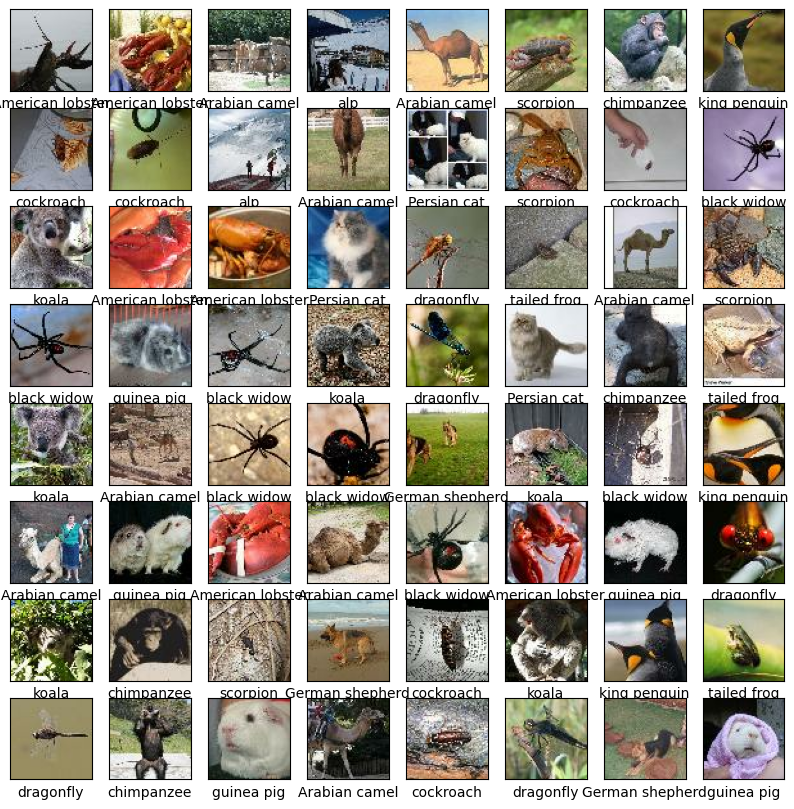

In [22]:
# Take one element from the dataset
sample = ds_train_aug.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # print( label)
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(limited_classes[np.argmax(label[i])])
    plt.show()
    break

Image shape: (64, 64, 64, 3)


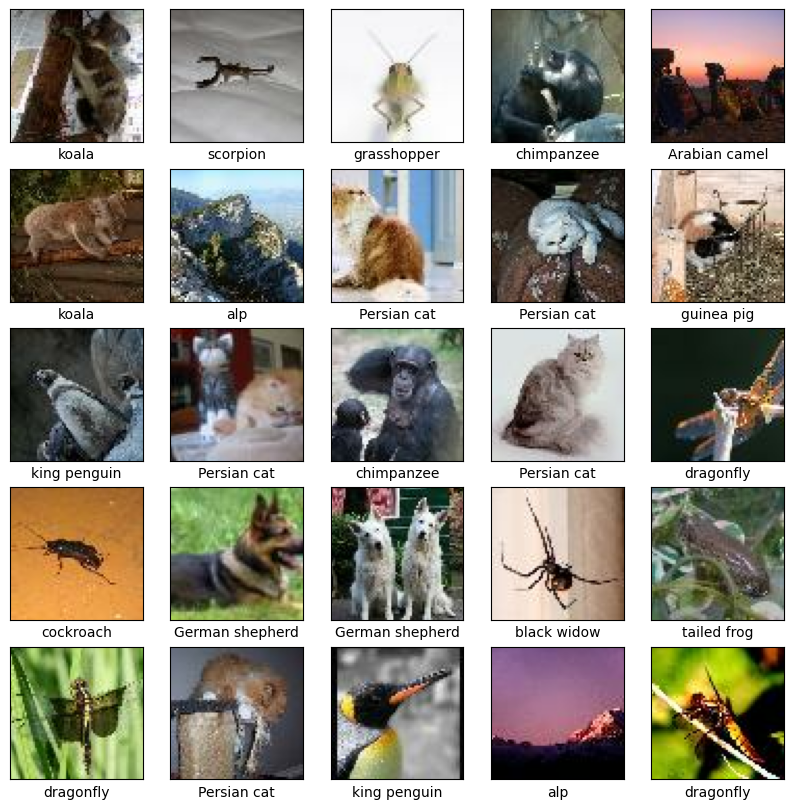

In [12]:
# Take one element from the dataset
sample = ds_valid.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # print( label)
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(limited_classes[np.argmax(label[i])])
    plt.show()
    break

Image shape: (64, 64, 64, 3)


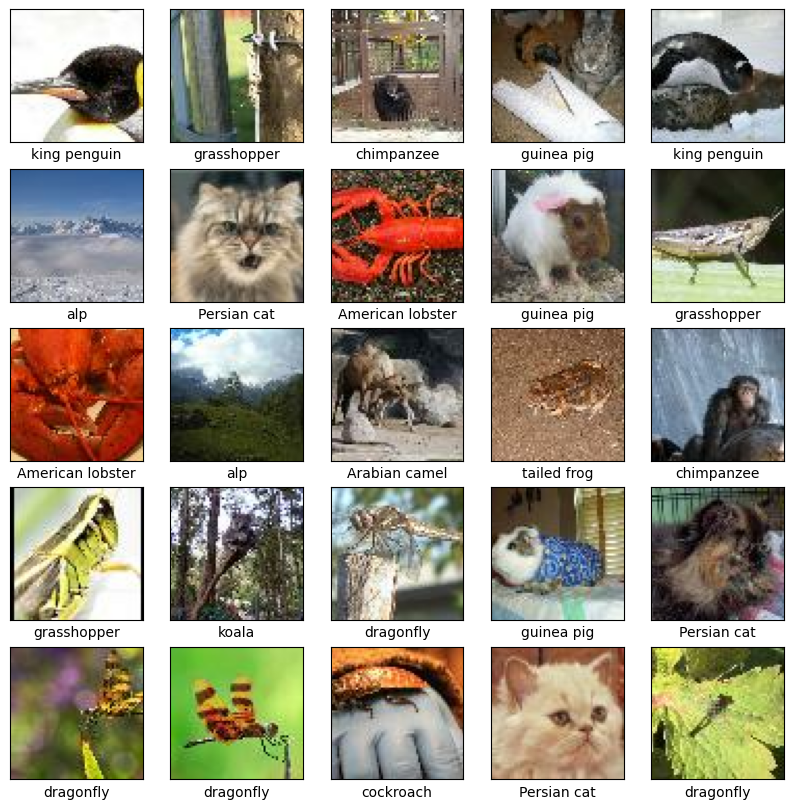

In [13]:
# Take one element from the dataset
sample = ds_train.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(limited_classes[np.argmax(label[i])])

    plt.show()
    break


In [15]:
# # Take one element from the dataset
# sample = ds_valid_aug.take(1)

# plt.figure(figsize=(10,10))
# # Iterate through the dataset and print images and label
# for image, label in sample:
#     # print( label)
#     # Convert image tensor to NumPy array for visualization
#     image_np = image.numpy()
#     print("Image shape:", image_np.shape)
#     for i in range(25):
#         plt.subplot(5,5,i+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         plt.imshow(image_np[i])
#         plt.xlabel(limited_classes[np.argmax(label[i])])
#     plt.show()
#     break

Image shape: (64, 64, 64, 3)


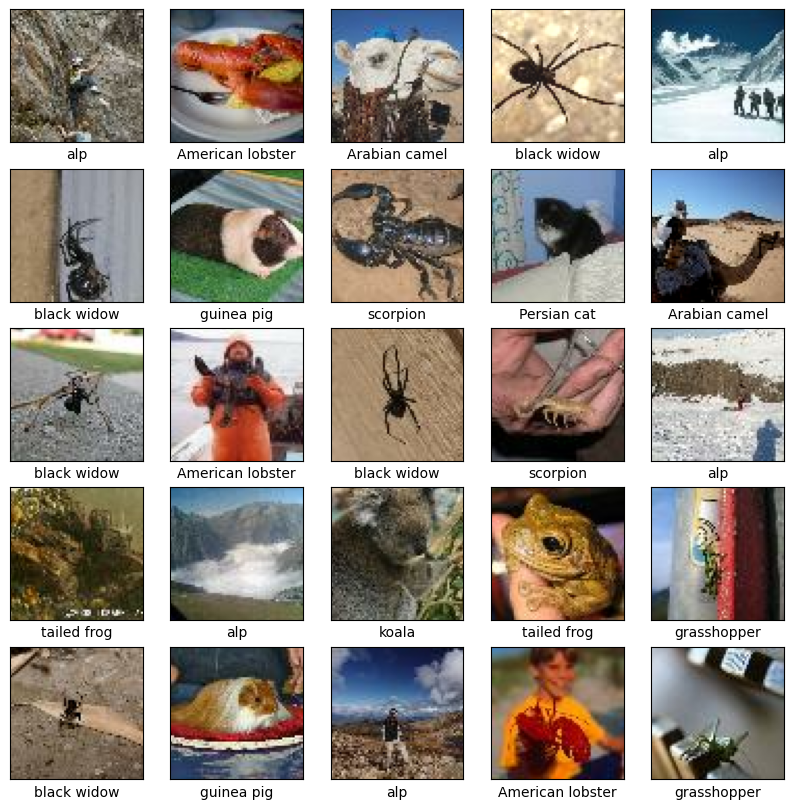

In [16]:
# Take one element from the dataset
sample = ds_train_aug.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(limited_classes[np.argmax(label[i])])

    plt.show()
    break

In [17]:
## plot functions 
def plot_hist_loss(hist):
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title("Training loss VS Validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_hist(hist):
    plt.plot(hist.history["accuracy"], label='Training Accuracy')
    plt.plot(hist.history["val_accuracy"], label='Validation Accuracy')
    plt.title("Training Accuracy VS Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

def plot_hist_comp(hist, hist1, label1 , label2):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['accuracy'], label='Train-WOR Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation-WOR Accuracy')
    plt.plot(hist1.history["accuracy"], label= label1)
    plt.plot(hist1.history["val_accuracy"], label= label2)
    plt.title("Training Accuracy VS Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_hist_comp_loss(hist, hist1,label1 , label2 ):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['loss'], label='Train-WOR Loss')
    plt.plot(hist.history['val_loss'], label='Validation-WOR Loss')
    plt.plot(hist1.history["loss"], label= label1)
    plt.plot(hist1.history["val_loss"], label= label2)
    plt.title("Training loss VS Validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


In [18]:
# # Define the input shape
# input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# # Define the model architecture
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
#     tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
#     tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
#     tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
#     tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
#     tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
#     tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# # Compile the model
# model.compile(
#     optimizer="adam",
#     loss="categorical_crossentropy",
#     metrics=['accuracy'])

# # Print the model summary
# print(model.summary())

# class LogMetricsCallback(tf.keras.callbacks.Callback):
#     def __init__(self, filename):
#         super(LogMetricsCallback, self).__init__()
#         self.filename = filename
#         # Initialize the file with headers
#         with open(self.filename, 'w', newline='') as f:
#             writer = csv.writer(f)
#             writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

#     def on_epoch_end(self, epoch, logs=None):
#         with open(self.filename, 'a', newline='') as f:
#             writer = csv.writer(f)
#             writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

# output_file = "model.csv"
# log_metrics_callback = LogMetricsCallback(output_file)
# # Train the model
# model_output = model.fit(
#     ds_train, 
#     epochs=EPOCHS, 
#     validation_data=ds_valid, 
#     batch_size=BATCH_SIZE,
#     callbacks=[log_metrics_callback],
#     )

# # Evaluate the model
# loss, accuracy = model.evaluate(ds_valid)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

In [19]:
# plot_hist_loss(model_output)
# plot_hist(model_output)

In [20]:
# # Define the input shape
# input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# # Define the model architecture
# model_l2 = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
#     tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
#     tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
#     tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
#     tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
#     tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
#     tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
#     tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# # Compile the model
# model_l2.compile(
#     optimizer="adam", 
#     loss="categorical_crossentropy",
#     metrics=['accuracy'])

# # Print the model summary
# print(model_l2.summary())

# class LogMetricsCallback(tf.keras.callbacks.Callback):
#     def __init__(self, filename):
#         super(LogMetricsCallback, self).__init__()
#         self.filename = filename
#         # Initialize the file with headers
#         with open(self.filename, 'w', newline='') as f:
#             writer = csv.writer(f)
#             writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

#     def on_epoch_end(self, epoch, logs=None):
#         with open(self.filename, 'a', newline='') as f:
#             writer = csv.writer(f)
#             writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

# output_file = "model_l2.csv"
# log_metrics_callback = LogMetricsCallback(output_file)
# # Train the model
# model_output_l2 = model_l2.fit(
#     ds_train, 
#     epochs=EPOCHS, 
#     validation_data=ds_valid, 
#     batch_size=BATCH_SIZE,
#     callbacks = [log_metrics_callback]
#     )

# # Evaluate the model
# loss, accuracy = model_l2.evaluate(ds_valid)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

In [21]:
# plot_hist_loss(model_output_l2)
# plot_hist(model_output_l2)

In [23]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_aug = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model_aug.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_aug.summary())

class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(LogMetricsCallback, self).__init__()
        self.filename = filename
        # Initialize the file with headers
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

output_file = "model_aug.csv"
log_metrics_callback = LogMetricsCallback(output_file)
# Train the model
model_output_aug = model_aug.fit(
    ds_train_aug, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    callbacks=[log_metrics_callback],
    )

# Evaluate the model
loss, accuracy = model_aug.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Users/hrishikesh/miniconda3/envs/ML_HW1/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321,679 (20.30 MB)

 Trainable params: 5,321,679 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25


In [ ]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_dropout = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model_dropout.compile(
    optimizer="adam",  
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_dropout.summary())

class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(LogMetricsCallback, self).__init__()
        self.filename = filename
        # Initialize the file with headers
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']])

output_file = "model_dropout.csv"
log_metrics_callback = LogMetricsCallback(output_file)
# Train the model
model_output_dropout = model_dropout.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    callbacks=[log_metrics_callback]
    )

# Evaluate the model
loss, accuracy = model_dropout.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,321,679 (20.30 MB)

 Trainable params: 5,321,679 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 0.0720 - loss: 3.2376 - val_accuracy: 0.1236 - val_loss: 2.5994
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.1097 - loss: 2.6125 - val_accuracy: 0.1165 - val_loss: 2.6207
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.1401 - loss: 2.5436 - val_accuracy: 0.2017 - val_loss: 2.4650
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.1925 - loss: 2.4390 - val_accuracy: 0.2003 - val_loss: 2.4018
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 0.2308 - loss: 2.3429 - val_accuracy: 0.2401 - val_loss: 2.2996
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.2556 - loss: 2.2650 - val_accuracy: 0.2642 - val_loss: 2.2402
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.2687 - loss: 2.2140 - val_accuracy: 0.2898 - val_loss: 2.1942
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.3031 - lo

In [ ]:
plot_hist_comp_loss(model_output , model_output_l2 ,Train-l2-loss , Validation-l2-loss)
plot_hist_comp(model_output , model_output_l2, Train-l2-Accuracy , Validation-l2-Accuracy)